In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('chineseMNIST.csv')
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [5]:
df.shape

(15000, 4098)

In [7]:
df_label = df['label']
df_images = df.drop(columns=['label', 'character'])
df_images.shape, df_label.shape

((15000, 4096), (15000,))

In [9]:
print(f"Characters: {df['character'].nunique()}: {list(df['character'].unique())}")
print(f"Numbers: {df['label'].nunique()}: {list(df['label'].unique())}")

Characters: 15: ['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
Numbers: 15: [9, 10, 100, 1000, 10000, 100000000, 0, 1, 2, 3, 4, 5, 6, 7, 8]


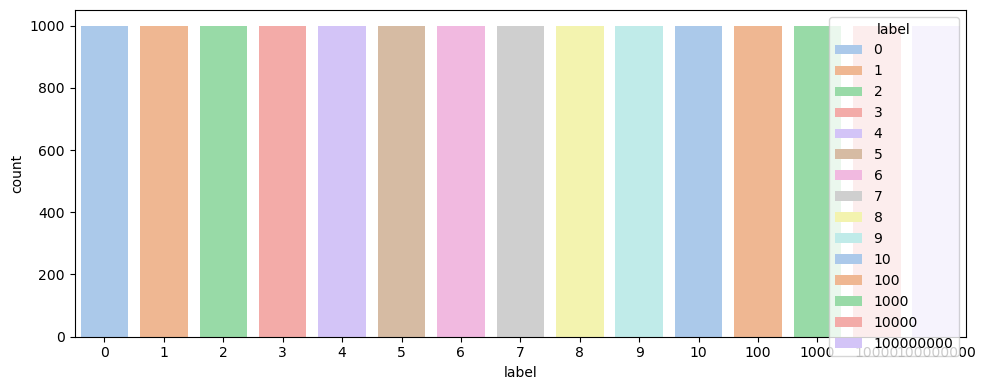

In [11]:
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x='label', y='count', data=label_counts, hue='label', palette='pastel')
plt.tight_layout()
plt.show()

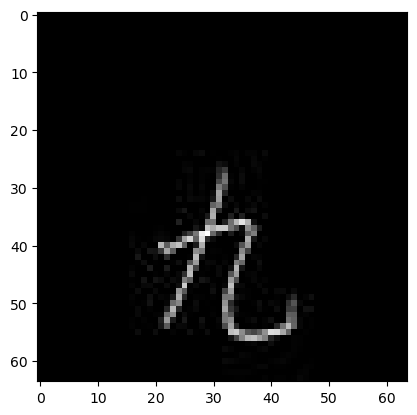

In [13]:
plt.imshow(df_images.iloc[0].values.reshape(64,64), cmap='gray')

In [15]:
df_images_norm = df_images/255.0

In [17]:
df_label.replace(100, 11, inplace=True)
df_label.replace(1000, 12, inplace=True)
df_label.replace(10000, 13, inplace=True)
df_label.replace(100000000, 14, inplace=True)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_images_norm, df_label, test_size=0.2, random_state=42)

In [21]:
def init_params():
    
    W1 = np.random.randn(128, 4096) * np.sqrt(2. / 4096)
    b1 = np.zeros((128, 1))
    
    W2 = np.random.randn(64, 128) * np.sqrt(2. / 128)
    b2 = np.zeros((64, 1))
    
    W3 = np.random.randn(15, 64) * np.sqrt(2. / 64)
    b3 = np.zeros((15, 1))
    
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, W3, b3, X):
    
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    
    return Z1, A1, Z2, A2, Z3, A3

def ReLU_deriv(Z):
    return (Z > 0).astype(float)

def one_hot(Y, num_classes=15):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    
    m = Y.size
    one_hot_Y = one_hot(Y, num_classes=A3.shape[0])
    
    dZ3 = A3 - one_hot_Y
    dW3 = (1 / m) * dZ3.dot(A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2

    W3 = W3 - alpha * dW3  
    b3 = b3 - alpha * db3
    
    return W1, b1, W2, b2, W3, b3

In [23]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def compute_loss(A3, Y):
    m = Y.size
    one_hot_Y = one_hot(Y, num_classes=A3.shape[0])
    log_probs = np.log(A3 + 1e-8)
    return -np.sum(one_hot_Y * log_probs) / m

In [25]:
from tqdm import tqdm
def gradient_descent(X, Y, alpha, iterations):
    X = np.array(X).T
    Y = np.array(Y).T
    W1, b1, W2, b2, W3, b3 = init_params()

    for i in tqdm(range(iterations + 1), desc="Training"):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A3)
            acc = get_accuracy(predictions, Y)
            loss = compute_loss(A3, Y)
            print(f"Iteration {i}: Accuracy = {acc:.2%}, Loss = {loss:.4f}")
    
    return W1, b1, W2, b2, W3, b3

In [27]:
W1_grad, b1_grad, W2_grad, b2_grad, W3_grad, b3_grad = gradient_descent(X_train, y_train, 0.50, 1000)

Training:   0%|          | 1/1001 [00:00<15:16,  1.09it/s]

Iteration:  0
[ 7 12  6 ...  9  0 12] [ 3  3  1 ... 14  9  1]
Iteration 0: Accuracy = 7.03%, Loss = 2.7109


Training:  10%|█         | 101/1001 [00:51<07:16,  2.06it/s]

Iteration:  100
[ 1  2  1 ... 14 14  1] [ 3  3  1 ... 14  9  1]
Iteration 100: Accuracy = 52.90%, Loss = 1.5354


Training:  20%|██        | 201/1001 [01:41<06:35,  2.02it/s]

Iteration:  200
[ 2  2  1 ... 14  6  1] [ 3  3  1 ... 14  9  1]
Iteration 200: Accuracy = 65.46%, Loss = 1.0950


Training:  30%|███       | 301/1001 [02:31<06:10,  1.89it/s]

Iteration:  300
[ 2  3  8 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 300: Accuracy = 69.90%, Loss = 0.9433


Training:  40%|████      | 401/1001 [03:25<05:34,  1.80it/s]

Iteration:  400
[ 2  3  2 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 400: Accuracy = 87.47%, Loss = 0.4517


Training:  50%|█████     | 501/1001 [04:18<05:04,  1.64it/s]

Iteration:  500
[ 2  3  2 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 500: Accuracy = 89.84%, Loss = 0.3480


Training:  60%|██████    | 601/1001 [04:49<02:06,  3.15it/s]

Iteration:  600
[ 2  3  2 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 600: Accuracy = 95.34%, Loss = 0.2096


Training:  70%|███████   | 701/1001 [05:25<01:37,  3.07it/s]

Iteration:  700
[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 700: Accuracy = 95.78%, Loss = 0.1661


Training:  80%|████████  | 801/1001 [05:55<00:52,  3.82it/s]

Iteration:  800
[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 800: Accuracy = 98.22%, Loss = 0.1078


Training:  90%|█████████ | 901/1001 [06:24<00:32,  3.11it/s]

Iteration:  900
[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 900: Accuracy = 98.80%, Loss = 0.0815


Training: 100%|██████████| 1001/1001 [07:01<00:00,  2.38it/s]

Iteration:  1000
[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 1000: Accuracy = 98.92%, Loss = 0.0828


In [28]:
from tqdm import tqdm
def batch_gradient_descent(X, Y, alpha, iterations, batch_size):
    X = np.array(X).T  
    Y = np.array(Y)
    m = X.shape[1]     

    W1, b1, W2, b2, W3, b3 = init_params()

    for i in tqdm(range(iterations + 1), desc="Training"):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]

        for j in range(0, m, batch_size):
            X_batch = X_shuffled[:, j:j+batch_size]
            Y_batch = Y_shuffled[j:j+batch_size]

            Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X_batch)
            dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X_batch, Y_batch)
            W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3,
                                                   dW1, db1, dW2, db2, dW3, db3, alpha)

        if i % 20 == 0:
            Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
            predictions = get_predictions(A3)
            acc = get_accuracy(predictions, Y)
            loss = compute_loss(A3, Y)
            print(f"Iteration {i}: Accuracy = {acc:.2%}, Loss = {loss:.4f}")

    return W1, b1, W2, b2, W3, b3


In [37]:
W1_batch, b1_batch, W2_batch, b2_batch, W3_batch, b3_batch = batch_gradient_descent(X_train, y_train, alpha=0.01, iterations=100, batch_size=64)

Training:   1%|          | 1/101 [00:02<04:39,  2.79s/it]

[14 13 13 ...  7 13 10] [ 3  3  1 ... 14  9  1]
Iteration 0: Accuracy = 13.20%, Loss = 2.6739


Training:  21%|██        | 21/101 [00:51<03:26,  2.58s/it]

[ 1  2  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 20: Accuracy = 53.61%, Loss = 1.5797


Training:  41%|████      | 41/101 [01:44<02:36,  2.61s/it]

[ 8  2  1 ... 14 14  1] [ 3  3  1 ... 14  9  1]
Iteration 40: Accuracy = 65.94%, Loss = 1.1657


Training:  60%|██████    | 61/101 [02:37<01:50,  2.75s/it]

[ 2  2  1 ... 14 14  1] [ 3  3  1 ... 14  9  1]
Iteration 60: Accuracy = 77.49%, Loss = 0.7931


Training:  80%|████████  | 81/101 [03:34<00:58,  2.92s/it]

[ 2  2  8 ... 14 14  1] [ 3  3  1 ... 14  9  1]
Iteration 80: Accuracy = 85.54%, Loss = 0.5428


Training: 100%|██████████| 101/101 [04:32<00:00,  2.70s/it]

[ 2  2  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 100: Accuracy = 90.34%, Loss = 0.3866


In [38]:
def stochastic_gradient_descent(X, Y, alpha, iterations):
    X = np.array(X).T  # shape: (features, samples)
    Y = np.array(Y)
    m = X.shape[1]

    W1, b1, W2, b2, W3, b3 = init_params()

    for i in tqdm(range(iterations + 1), desc="Training"):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]

        for j in range(m):
            X_sample = X_shuffled[:, j:j+1]  # shape: (features, 1)
            Y_sample = Y_shuffled[j:j+1]     # shape: (1,)

            Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X_sample)
            dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3,
                                                         W1, W2, W3, X_sample, Y_sample)
            W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3,
                                                   dW1, db1, dW2, db2, dW3, db3, alpha)

        if i % 10 == 0:
            Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
            predictions = get_predictions(A3)
            acc = get_accuracy(predictions, Y)
            loss = compute_loss(A3, Y)
            tqdm.write(f"Iteration {i}: Accuracy = {acc:.2%}, Loss = {loss:.4f}")

    return W1, b1, W2, b2, W3, b3

In [39]:
W1_sgd, b1_sgd, W2_sgd, b2_sgd, W3_sgd, b3_sgd = stochastic_gradient_descent(X_train, y_train, alpha=0.001, iterations=50)

Training:   2%|▏         | 1/51 [01:27<1:12:51, 87.42s/it]

[ 1  7  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 0: Accuracy = 33.24%, Loss = 2.3333


Training:  22%|██▏       | 11/51 [15:17<54:55, 82.38s/it] 

[ 2  2  1 ... 14 14  1] [ 3  3  1 ... 14  9  1]
Iteration 10: Accuracy = 79.54%, Loss = 0.7206


Training:  41%|████      | 21/51 [28:59<38:00, 76.03s/it]

[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 20: Accuracy = 93.60%, Loss = 0.2736


Training:  61%|██████    | 31/51 [40:47<24:32, 73.65s/it]

[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 30: Accuracy = 98.39%, Loss = 0.1155


Training:  80%|████████  | 41/51 [52:02<11:25, 68.55s/it]

[ 2  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 40: Accuracy = 99.42%, Loss = 0.0578


Training: 100%|██████████| 51/51 [1:04:25<00:00, 75.79s/it]

[ 3  3  1 ... 14  9  1] [ 3  3  1 ... 14  9  1]
Iteration 50: Accuracy = 99.83%, Loss = 0.0332


In [40]:
def test_accuracy(Y, predictions):
    return np.sum(predictions == Y) / Y.size

In [49]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    X = np.array(X).T
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

In [51]:
y_pred_grad = make_predictions(X_test, W1_grad, b1_grad, W2_grad, b2_grad, W3_grad, b3_grad)
print('Full batch Gradient Descent Accuracy = ', test_accuracy(y_test, y_pred_grad))

y_pred_batch = make_predictions(X_test, W1_batch, b1_batch, W2_batch, b2_batch, W3_batch, b3_batch)
print('Mini batches Gradient Descent Accuracy = ', test_accuracy(y_test, y_pred_batch))

y_pred_sgd = make_predictions(X_test, W1_sgd, b1_sgd, W2_sgd, b2_sgd, W3_sgd, b3_sgd)
print('Stochastic Gradient Descent Accuracy = ', test_accuracy(y_test, y_pred_sgd))

Full batch Gradient Descent Accuracy =  0.806
Mini batches Gradient Descent Accuracy =  0.7396666666666667
Stochastic Gradient Descent Accuracy =  0.788


In [53]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

Full batch Gradient Descent


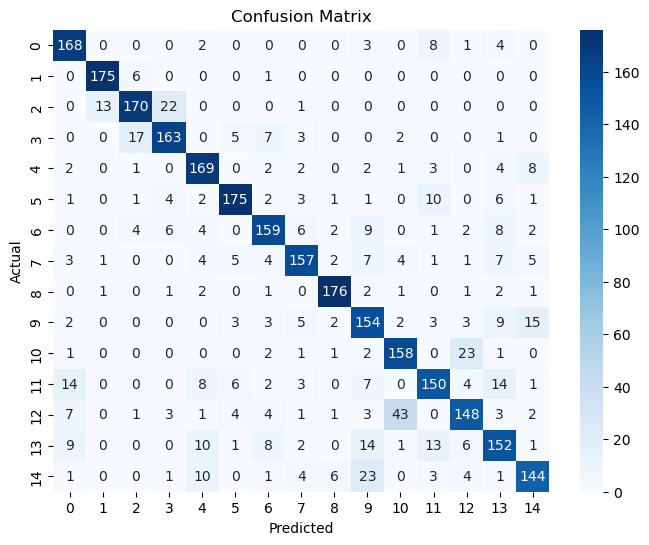

Mini batches Gradient Descent


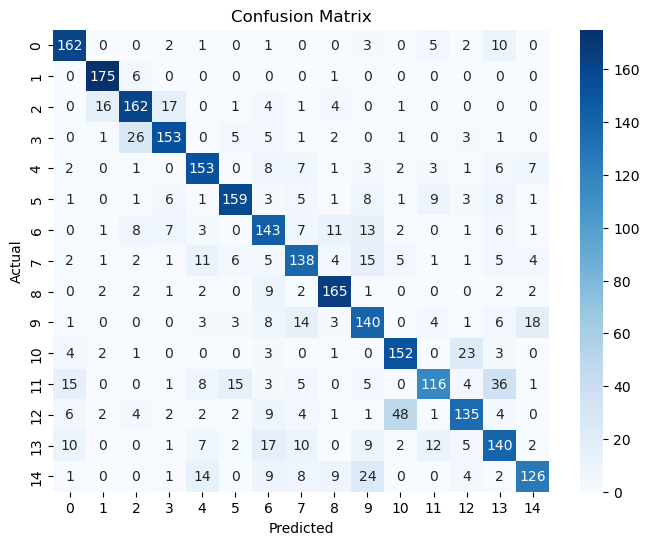

Stochastic batch Gradient Descent


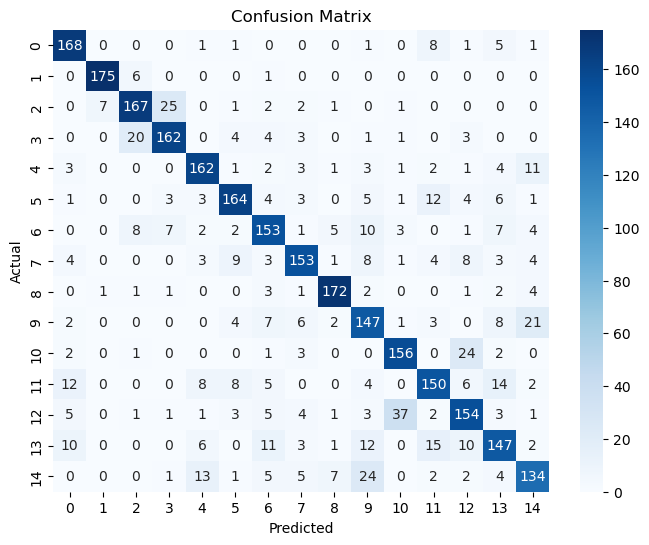

In [55]:
print('Full batch Gradient Descent')
plot_confusion_matrix(y_test, y_pred_grad)
print('Mini batches Gradient Descent')
plot_confusion_matrix(y_test, y_pred_batch)
print('Stochastic batch Gradient Descent')
plot_confusion_matrix(y_test, y_pred_sgd)

In [57]:
y_pred_grad = make_predictions(df_images_norm, W1_grad, b1_grad, W2_grad, b2_grad, W3_grad, b3_grad)
print('Full batch Gradient Descent Accuracy = ', test_accuracy(df_label, y_pred_grad))

y_pred_batch = make_predictions(df_images_norm, W1_batch, b1_batch, W2_batch, b2_batch, W3_batch, b3_batch)
print('Mini batches Gradient Descent Accuracy = ', test_accuracy(df_label, y_pred_batch))

y_pred_sgd = make_predictions(df_images_norm, W1_sgd, b1_sgd, W2_sgd, b2_sgd, W3_sgd, b3_sgd)
print('Stochastic Gradient Descent Accuracy = ', test_accuracy(df_label, y_pred_sgd))

Full batch Gradient Descent Accuracy =  0.9529333333333333
Mini batches Gradient Descent Accuracy =  0.8706666666666667
Stochastic Gradient Descent Accuracy =  0.9562


In [129]:
def row_to_image(row, shape=(64, 64), show=True, save_path=None):
    if not isinstance(row, np.ndarray):
        row = row.to_numpy()
    
    image = row.reshape(shape)
    
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return image

In [131]:
import random
def test_cases(n):
    for i in range(n):
        index = random.randint(0, 15000)
        row_to_image(df_images_norm.iloc[index], shape=(64, 64))
        print('Index:                 ', index)
        print('Character:             ', df.character.iloc[index])
        print('Actual Label:          ', df_label.iloc[index])
        print('Full batch GD label:   ', y_pred_grad[index])
        print('Mini batches GD label: ', y_pred_batch[index])
        print('Stochastic GD label:   ', y_pred_sgd[index])

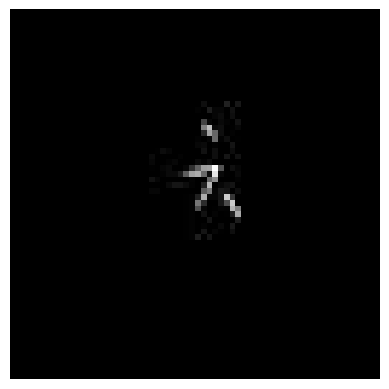

Index:                  12858
Character:              六
Actual Label:           6
Full batch GD label:    6
Mini batches GD label:  6
Stochastic GD label:    6


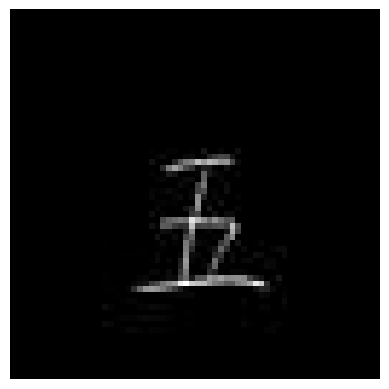

Index:                  11318
Character:              五
Actual Label:           5
Full batch GD label:    5
Mini batches GD label:  5
Stochastic GD label:    5


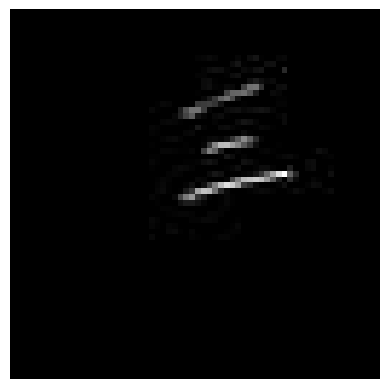

Index:                  9232
Character:              三
Actual Label:           3
Full batch GD label:    2
Mini batches GD label:  2
Stochastic GD label:    2


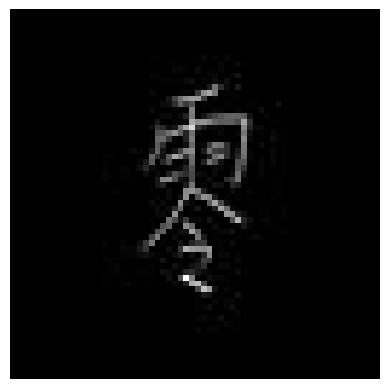

Index:                  6456
Character:              零
Actual Label:           0
Full batch GD label:    0
Mini batches GD label:  0
Stochastic GD label:    0


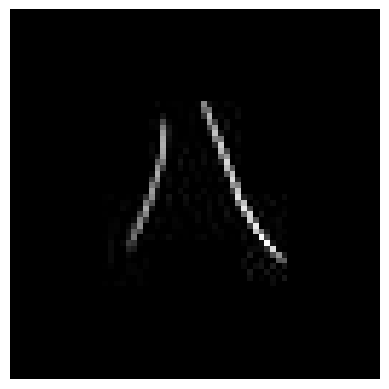

Index:                  14675
Character:              八
Actual Label:           8
Full batch GD label:    8
Mini batches GD label:  8
Stochastic GD label:    8


In [150]:
test_cases(5)